In [ ]:
! pip install transformers==4.28.0 datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.1
    Uninstalling tokenizers-0.15.1:
      Successfully uninstalled tokenizers-0.15.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


# Image classification

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load dataset

In [ ]:
from datasets import load_dataset

food = load_dataset("juanfengyun/SEEDTrain", split="train[:325]")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset

ds= load_dataset("/content/drive/MyDrive/MFCC/BB1",split="train")

Resolving data files:   0%|          | 0/523 [00:00<?, ?it/s]

Split the dataset's `train` split into a train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method:

In [ ]:
ds

Dataset({
    features: ['image', 'label'],
    num_rows: 523
})

In [ ]:
ds.data

MemoryMappedTable
image: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
label: int64
----
image: [
  -- is_valid: all not null
  -- child 0 type: binary
[null,null,null,null,null,...,null,null,null,null,null]
  -- child 1 type: string
["/content/drive/MyDrive/MFCC/BB1/Disorder/2AU201-01DM4_9SSD-BB01.png","/content/drive/MyDrive/MFCC/BB1/Disorder/2AU201-01DM4_9SSD-BB02.png","/content/drive/MyDrive/MFCC/BB1/Disorder/2AU201-01DM4_9SSD-BB03.png","/content/drive/MyDrive/MFCC/BB1/Disorder/2AU201-01DM4_9SSD-BB04.png","/content/drive/MyDrive/MFCC/BB1/Disorder/2AU201-01DM4_9SSD-BB05.png",...,"/content/drive/MyDrive/MFCC/BB1/NonDisorder/2AU201-31NF7_10-BB29.png","/content/drive/MyDrive/MFCC/BB1/NonDisorder/2AU201-31NF7_10-BB30.png","/content/drive/MyDrive/MFCC/BB1/NonDisorder/2AU201-31NF7_10-BB31.png","/content/drive/MyDrive/MFCC/BB1/NonDisorder/2AU201-31NF7_10-BB32.png","/content/drive/MyDrive/MFCC/BB1/NonDisorder/2AU201-31NF7_10-BB33.png"]]
label: [[0,0,0,

In [ ]:
ds = ds.train_test_split(test_size=0.2)

In [ ]:
ds


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 418
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 105
    })
})

Each example in the dataset has two fields:

- `image`: a PIL image of the food item
- `label`: the label class of the food item

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name
to an integer and vice versa:

In [ ]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

Now you can convert the label id to a label name:

In [ ]:
labels

['Disorder', 'NonDisorder']

In [ ]:
id2label

{'0': 'Disorder', '1': 'NonDisorder'}

## Preprocess

The next step is to load a ViT image processor to process the image into a tensor:

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Apply some image transformations to the images to make the model more robust against overfitting. Here you'll use torchvision's [`transforms`](https://pytorch.org/vision/stable/transforms.html) module, but you can also use any image library you like.

Crop a random part of the image, resize it, and normalize it with the image mean and standard deviation:

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

Then create a preprocessing function to apply the transforms and return the `pixel_values` - the inputs to the model - of the image:

In [ ]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. The transforms are applied on the fly when you load an element of the dataset:

In [ ]:
ds = ds.with_transform(transforms)

In [ ]:
testDs = ds["test"]

In [ ]:
testDs

Dataset({
    features: ['image', 'label'],
    num_rows: 105
})

In [ ]:
testDs = load_dataset("/content/drive/MyDrive/Colab Notebooks/SpeechClassification/test")

Resolving data files:   0%|          | 0/112 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
testDs

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 112
    })
})

In [ ]:
prepared_Test = testDs.with_transform(transforms)

Now create a batch of examples using [DefaultDataCollator](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DefaultDataCollator). Unlike other data collators in 🤗 Transformers, the `DefaultDataCollator` does not apply additional preprocessing such as padding.

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load an
evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load
the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import evaluate


In [ ]:
metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

Call compute on metric to calculate the accuracy of your predictions. Before passing your predictions to compute, you need to convert the logits to predictions (remember all 🤗 Transformers models return logits):


In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metrics.compute(predictions=predictions, references=labels)

Your `compute_metrics` function is ready to go now, and you'll return to it when you set up your training.

In [ ]:
!pip install wandb
import wandb

wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load ViT with [AutoModelForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForImageClassification). Specify the number of labels along with the number of expected labels, and the label mappings:

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). It is important you don't remove unused columns because this'll drop the `image` column. Without the `image` column, you can't create `pixel_values`. Set `remove_unused_columns=False` to prevent this behavior! The only other required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the accuracy and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [ ]:
pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
pip install transformers==4.28.0

In [ ]:
training_args = TrainingArguments(
    output_dir="./my_MFCC_VITmodelBBMetrics",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=80,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    #  report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    # eval_dataset=food["test"],
    eval_dataset=ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/juanfengyun/my_MFCC_VITmodelBBMetrics into local empty directory.


Download file pytorch_model.bin:   0%|          | 9.45k/327M [00:00<?, ?B/s]

Download file runs/Feb03_21-04-47_6afb7c2c656c/events.out.tfevents.1706994367.6afb7c2c656c.574.0:  17%|#7     …

Download file runs/Feb02_07-34-19_b4c9a8928d8e/events.out.tfevents.1706859261.b4c9a8928d8e.2069.2:  26%|##5   …

Download file runs/Feb02_07-31-37_b4c9a8928d8e/1706859102.84772/events.out.tfevents.1706859102.b4c9a8928d8e.20…

Download file runs/Feb02_09-08-43_b4c9a8928d8e/1706864925.9732056/events.out.tfevents.1706864925.b4c9a8928d8e.…

Clean file runs/Feb03_21-04-47_6afb7c2c656c/events.out.tfevents.1706994367.6afb7c2c656c.574.0:   2%|1         …

Download file runs/Feb03_21-04-47_6afb7c2c656c/1706994367.1599114/events.out.tfevents.1706994367.6afb7c2c656c.…

Download file runs/Feb02_09-08-43_b4c9a8928d8e/events.out.tfevents.1706864925.b4c9a8928d8e.2069.4: 100%|######…

Clean file runs/Feb02_07-31-37_b4c9a8928d8e/1706859102.84772/events.out.tfevents.1706859102.b4c9a8928d8e.2069.…

Clean file runs/Feb02_07-34-19_b4c9a8928d8e/events.out.tfevents.1706859261.b4c9a8928d8e.2069.2:   2%|1        …

Download file runs/Feb02_07-34-19_b4c9a8928d8e/1706859261.6466358/events.out.tfevents.1706859261.b4c9a8928d8e.…

Clean file runs/Feb02_09-08-43_b4c9a8928d8e/1706864925.9732056/events.out.tfevents.1706864925.b4c9a8928d8e.206…

Clean file runs/Feb03_21-04-47_6afb7c2c656c/1706994367.1599114/events.out.tfevents.1706994367.6afb7c2c656c.574…

Clean file runs/Feb02_09-08-43_b4c9a8928d8e/events.out.tfevents.1706864925.b4c9a8928d8e.2069.4:  22%|##2      …

Clean file runs/Feb02_07-34-19_b4c9a8928d8e/1706859261.6466358/events.out.tfevents.1706859261.b4c9a8928d8e.206…

Download file runs/Feb02_07-31-37_b4c9a8928d8e/events.out.tfevents.1706859102.b4c9a8928d8e.2069.0: 100%|######…

Clean file runs/Feb02_07-31-37_b4c9a8928d8e/events.out.tfevents.1706859102.b4c9a8928d8e.2069.0:  25%|##5      …

Download file training_args.bin: 100%|##########| 3.99k/3.99k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/3.99k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/327M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.691704,0.523810,0.509804,0.577778,0.456140
1,0.691000,0.684656,0.533333,0.671141,0.543478,0.877193
2,0.684500,0.685464,0.590476,0.565657,0.666667,0.491228
4,0.684500,0.671378,0.590476,0.671756,0.594595,0.771930
4,0.661800,0.678519,0.571429,0.701987,0.563830,0.929825
5,0.649100,0.653099,0.638095,0.672414,0.661017,0.684211
6,0.649100,0.686954,0.561905,0.510638,0.648649,0.421053
8,0.638500,0.652171,0.638095,0.586957,0.771429,0.473684
8,0.625500,0.623586,0.685714,0.736000,0.676471,0.807018
9,0.625500,0.691566,0.571429,0.640000,0.588235,0.701754


TrainOutput(global_step=480, training_loss=0.3509568723539511, metrics={'train_runtime': 2407.2891, 'train_samples_per_second': 13.891, 'train_steps_per_second': 0.199, 'total_flos': 2.3035268832833618e+18, 'train_loss': 0.3509568723539511, 'epoch': 71.11})

In [ ]:
wandb.finish()

In [ ]:
trainer.save_state()

In [ ]:
trainer.state.log_history

[{'eval_loss': 0.6917038559913635,
  'eval_accuracy': 0.5238095238095238,
  'eval_f1': 0.5098039215686275,
  'eval_precision': 0.5777777777777777,
  'eval_recall': 0.45614035087719296,
  'eval_runtime': 74.3103,
  'eval_samples_per_second': 1.413,
  'eval_steps_per_second': 0.094,
  'epoch': 0.89,
  'step': 6},
 {'loss': 0.691,
  'learning_rate': 1.0416666666666668e-05,
  'epoch': 1.48,
  'step': 10},
 {'eval_loss': 0.6846561431884766,
  'eval_accuracy': 0.5333333333333333,
  'eval_f1': 0.6711409395973155,
  'eval_precision': 0.5434782608695652,
  'eval_recall': 0.8771929824561403,
  'eval_runtime': 2.0457,
  'eval_samples_per_second': 51.328,
  'eval_steps_per_second': 3.422,
  'epoch': 1.93,
  'step': 13},
 {'loss': 0.6845,
  'learning_rate': 2.0833333333333336e-05,
  'epoch': 2.96,
  'step': 20},
 {'eval_loss': 0.6854643225669861,
  'eval_accuracy': 0.5904761904761905,
  'eval_f1': 0.5656565656565656,
  'eval_precision': 0.6666666666666666,
  'eval_recall': 0.49122807017543857,
  'e

In [ ]:
type(trainer.state.log_history[0])

dict

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.DataFrame(trainer.state.log_history)
data


,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,learning_rate,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.691704,0.523810,0.509804,0.577778,0.456140,74.3103,1.413,0.094,0.89,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.48,10,0.6910,0.000010,NaN,NaN,NaN,NaN,NaN
2,0.684656,0.533333,0.671141,0.543478,0.877193,2.0457,51.328,3.422,1.93,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.96,20,0.6845,0.000021,NaN,NaN,NaN,NaN,NaN
4,0.685464,0.590476,0.565657,0.666667,0.491228,2.0361,51.569,3.438,2.96,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.499592,0.771429,0.781818,0.811321,0.754386,2.0863,50.328,3.355,69.93,472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.534527,0.780952,0.792793,0.814815,0.771930,2.0981,50.045,3.336,70.96,479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.11,480,0.1523,0.000000,NaN,NaN,NaN,NaN,NaN
119,0.515816,0.847619,0.857143,0.872727,0.842105,2.0750,50.603,3.374,71.11,480,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.dropna(subset=['eval_accuracy', 'eval_loss'])

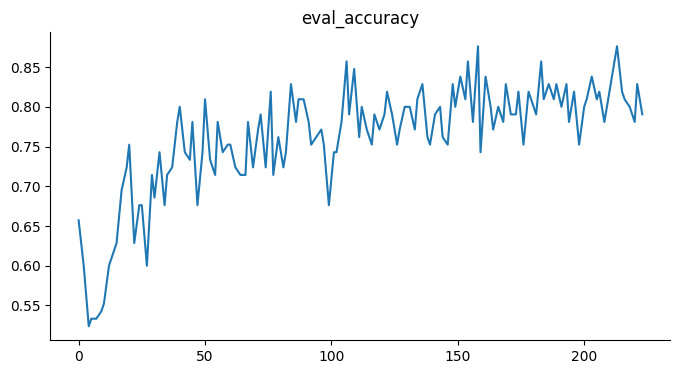

In [ ]:
from matplotlib import pyplot as plt
_df_13['eval_accuracy'].plot(kind='line', figsize=(8, 4), title='eval_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
_df_15['eval_samples_per_second'].plot(kind='line', figsize=(8, 4), title='eval_samples_per_second')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

<Axes: >

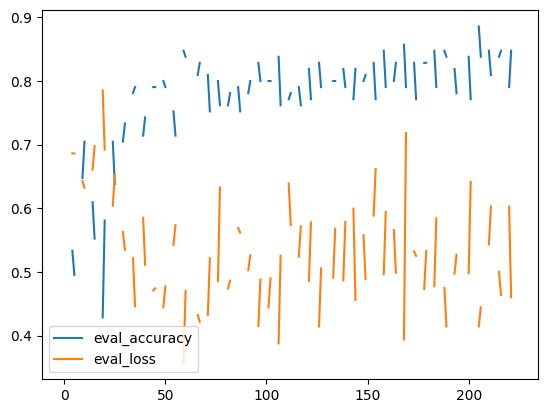

In [ ]:
data[['eval_accuracy','eval_loss']].plot()

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

Upload file runs/Feb07_08-13-05_5a9cb1b9b739/events.out.tfevents.1707293671.5a9cb1b9b739.3695.0:   0%|        …

To https://huggingface.co/juanfengyun/my_MFCC_VITmodelBBMetrics
   196c804..8afe0f7  main -> main

   196c804..8afe0f7  main -> main

To https://huggingface.co/juanfengyun/my_MFCC_VITmodelBBMetrics
   8afe0f7..c2ea013  main -> main

   8afe0f7..c2ea013  main -> main



'https://huggingface.co/juanfengyun/my_MFCC_VITmodelBBMetrics/commit/8afe0f77bfc93bbc0de7a289bd31697d4062e06a'

<Tip>

For a more in-depth example of how to finetune a model for image classification, take a look at the corresponding [PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb).

</Tip>

## Inference

Great, now that you've fine-tuned a model, you can use it for inference!

Load an image you'd like to run inference on:

In [ ]:
ds = load_dataset("juanfengyun/SEEDTest",split="test[:110]")


Resolving data files:   0%|          | 0/112 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
len(ds)

110

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    # eval_dataset=food["test"],
    eval_dataset=ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/./my_MFCC_VITmodelBBMetrics is already a clone of https://huggingface.co/juanfengyun/my_MFCC_VITmodelBBMetrics. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
ds['test']

Dataset({
    features: ['image', 'label'],
    num_rows: 105
})

In [ ]:
trainer.evaluate(ds['test'])

{'eval_loss': 0.33266088366508484,
 'eval_accuracy': 0.8761904761904762,
 'eval_f1': 0.8761904761904762,
 'eval_precision': 0.8070175438596491,
 'eval_recall': 0.9583333333333334,
 'eval_runtime': 2.0714,
 'eval_samples_per_second': 50.69,
 'eval_steps_per_second': 3.379}

In [ ]:
labels1 = prepared_Test["train"].features["label"].names
label2id1, id2label1 = dict(), dict()
for i, label in enumerate(labels1):
    label2id1[label] = str(i)
    id2label1[str(i)] = label

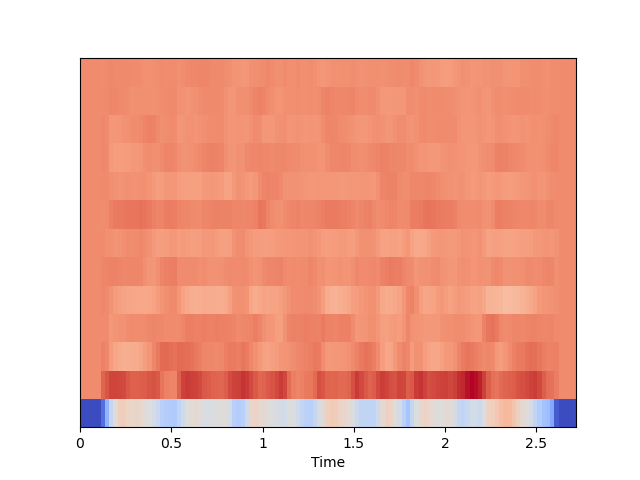

In [ ]:
image=ds["image"]
image[2]

In [ ]:
type(image)

list

In [ ]:
for i in range(10):
  image[i]

In [ ]:
labels1[0]

'disorder'

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="my_MFCC_VITmodel")
for i in range(110):
  list=classifier(image[i])
list
# for img in image:
#   classifier(img)

NameError: ignored

You can also manually replicate the results of the `pipeline` if you'd like:

Load an image processor to preprocess the image and return the `input` as PyTorch tensors:

In [ ]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_awesome_food_model")
inputs = image_processor(image, return_tensors="pt")

ValueError: ignored

Pass your inputs to the model and return the logits:

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_awesome_food_model")
with torch.no_grad():
    logits = model(**inputs).logits

NameError: ignored

Get the predicted label with the highest probability, and use the model's `id2label` mapping to convert it to a label:

In [ ]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'beignets'